In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Index_Calculations import facility_index_gen, index_and_generation
import os
import glob
import numpy as np

## Group state-level total gen into approx NERC regions
These definitions are taken from Pétron (2008).

Check actual generation from facilities in 2015 against the state-aggregation method

In [2]:
states_in_NERC = {'WECC': ['WA', 'OR', 'CA', 'NV', 'AZ', 'UT',
                           'ID', 'MT', 'WY', 'CO', 'NM'],
                  'MRO': ['ND', 'SD', 'NE', 'MN', 'IA', 'WI'],
                  'SPP': ['KS', 'OK'],
                  'ERCOT': ['TX'],
                  'SERC': ['MO', 'IL', 'AR', 'LA', 'MS', 'AL',
                           'GA', 'SC', 'NC', 'TN'],
                  'FRCC': ['FL'],
                  'RFC': ['MI', 'IN', 'OH', 'PA', 'WV', 'KY',
                          'VA', 'NJ', 'DE', 'MD'],
                  'NPCC': ['NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT']}

In [24]:
for nerc, states in states_in_NERC.iteritems():
    paths = [os.path.join('Data storage', 
                          'state gen data', 
                          state + ' fuels gen.csv') for state in states]
    nerc_list = [pd.read_csv(path) for path in paths]
    nerc_df = pd.concat(nerc_list)
    nerc_df.reset_index(inplace=True, drop=True)
    
    path_out = os.path.join('Data storage', 'state gen data', nerc + ' fuels gen.csv')
    nerc_df.to_csv(path_out, index=False)

## Calculate index values for each NERC region

In [25]:
facility_path = os.path.join('Data storage', 'Facility gen fuels and CO2 2017-05-25.zip')
epa_path = os.path.join('Data storage', 'Monthly EPA emissions 2017-05-25.csv')
ef_path = os.path.join('Data storage', 'Final emission factors.csv')
out_folder = os.path.join('Data storage', 'final NERC data from states')
NERC_path = os.path.join('Data storage', 'Facility NERC labels.csv')

for nerc in states_in_NERC.keys():
    all_fuel_path = os.path.join('Data storage', 'state gen data', nerc + ' fuels gen.csv')
    index_and_generation(facility_path=facility_path,
                         all_fuel_path = all_fuel_path,
                         epa_path=epa_path,
                         emission_factor_path=ef_path,
                         export_folder=out_folder, export_path_ext=' '
                         + nerc, state=states_in_NERC[nerc])

## Read data and create figures

In [3]:
path = os.path.join('Data storage', 'final NERC data from states', 'Monthly index*')
mi_fns = glob.glob(path)
path = os.path.join('Data storage', 'final NERC data from states', 'Monthly gen*')
mg_fns = glob.glob(path)

In [4]:
df_list = []
for f in mi_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_mi = pd.concat(df_list)
full_mi.reset_index(inplace=True, drop=True)
full_mi.rename(columns={'index (g/kWh)': 'monthly index (g/kWh)'}, inplace=True)
full_mi['datetime'] = pd.to_datetime(full_mi['datetime'])

In [5]:
df_list = []
for f in mg_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_mg = pd.concat(df_list)
full_mg.reset_index(inplace=True, drop=True)
full_mg['datetime'] = pd.to_datetime(full_mg['datetime'])

monthly_gen = pd.pivot_table(full_mg, index=['region', 'datetime'], 
                             values='generation (MWh)', columns='fuel category 1')
monthly_gen.reset_index(inplace=True, drop=False)
monthly_gen['Year'] = monthly_gen['datetime'].dt.year
monthly_gen.replace(np.nan, 0, inplace=True)

In [6]:
gen_index = pd.merge(monthly_gen, full_mi[['datetime', 'region', 'monthly index (g/kWh)']], 
                     on=['datetime', 'region'])

In [7]:
for region in gen_index['region'].unique():
    gen_index.loc[gen_index['region'] == region, 'Index variability'] = \
        gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).std()
    
    gen_index.loc[gen_index['region'] == region, 
                   'Normalized Index variability'] = \
         gen_index.loc[gen_index['region']==region, 'Index variability'] / \
         gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).mean()


In [8]:
base_year = 2005

In [9]:
fuels = ['Coal', 'Natural Gas', 'Other Renewables', 'Nuclear', 'Other',
         'Solar', 'Wind', 'Hydro']
# fuels = ['Coal', 'Natural Gas', 'Renewables', 'Nuclear', 'Other']
gen_index['Total gen'] = gen_index.loc[:, fuels].sum(axis=1)
for fuel in fuels:
    # New columns that are being added
    col_percent = 'percent ' + fuel
    col_change = 'change in ' + fuel

    # Calculate percent of generation from each fuel type
    gen_index[col_percent] = gen_index.loc[:, fuel] / gen_index.loc[:, 'Total gen']

    # Percent of fuel in region in base year (entire year)
    for region in gen_index['region'].unique():
        percent_fuel_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                          (gen_index['region'] == region), fuel].sum() / gen_index.loc[(gen_index['Year'] == 2001) & 
                                                                                                     (gen_index['region'] == region), 'Total gen'].sum()

        # Use percent of fuel in 2001 to calculate change for each region/month
        gen_index.loc[gen_index['region'] == region, 
                      col_change] = (gen_index.loc[gen_index['region'] == region, col_percent] - percent_fuel_base) / percent_fuel_base
    
# Change in variability compared to average base year value
for region in gen_index['region'].unique():
    norm_variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['region'] == region), 'Normalized Index variability'].mean()
    variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['region'] == region), 'Index variability'].mean()
    
    gen_index.loc[gen_index['region'] == region, 
                  'change in variability'] = (gen_index.loc[gen_index['region'] == region, 
                                                            'Index variability'] - variability_base) / variability_base
    
    gen_index.loc[gen_index['region'] == region, 
                  'change in norm variability'] = (gen_index.loc[gen_index['region'] == region, 
                                                            'Normalized Index variability'] - norm_variability_base) / norm_variability_base

In [45]:
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.plotting import *
from bokeh.layouts import gridplot, column
from bokeh.models import HoverTool, Div
from bokeh.palettes import viridis
from bokeh.charts import TimeSeries
from bokeh.io import export_svgs

In [11]:
output_notebook()

Loading BokehJS ...

In [12]:
def weighted_percent(df, fuel, year):
    all_fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Other Renewables',
                 'Wind', 'Solar', 'Hydro']
    temp = df.loc[df['Year'] == year, all_fuels]
    temp['Total'] = temp.sum(axis=1)
    
    weighted_per = temp[fuel].sum() / temp['Total'].sum() * 100
    return weighted_per

In [13]:
gen_index.columns

Index([u'region', u'datetime', u'Coal', u'Hydro', u'Natural Gas', u'Nuclear',
       u'Other', u'Other Renewables', u'Solar', u'Wind', u'Year',
       u'monthly index (g/kWh)', u'Index variability',
       u'Normalized Index variability', u'Total gen', u'percent Coal',
       u'change in Coal', u'percent Natural Gas', u'change in Natural Gas',
       u'percent Other Renewables', u'change in Other Renewables',
       u'percent Nuclear', u'change in Nuclear', u'percent Other',
       u'change in Other', u'percent Solar', u'change in Solar',
       u'percent Wind', u'change in Wind', u'percent Hydro',
       u'change in Hydro', u'change in variability',
       u'change in norm variability'],
      dtype='object')

### Actual and Normalized variability over time in each NERC region

At the national level, Index variability went up after 2007, and then dipped back down briefly in 2013. This trend can be seen in a few, but not all, of the regions.

I'm not sure what the cyclical trends in Index variability represent. These values are 12 month rolling standard deviations - they shouldn't be affected by seasonal variation. 
**Update:** Upticks in the variability or normalized variability could be due to one or more months where the Index value jumped up or down well outside the normal range. This would increase the rolling standard deviation for 12 months.

The normalized variability here is a 12 month rolling standard deviation of CO2 intensity divided by the 12 month rolling average. I'm suspicious of the results in MRO.

In [27]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.2)

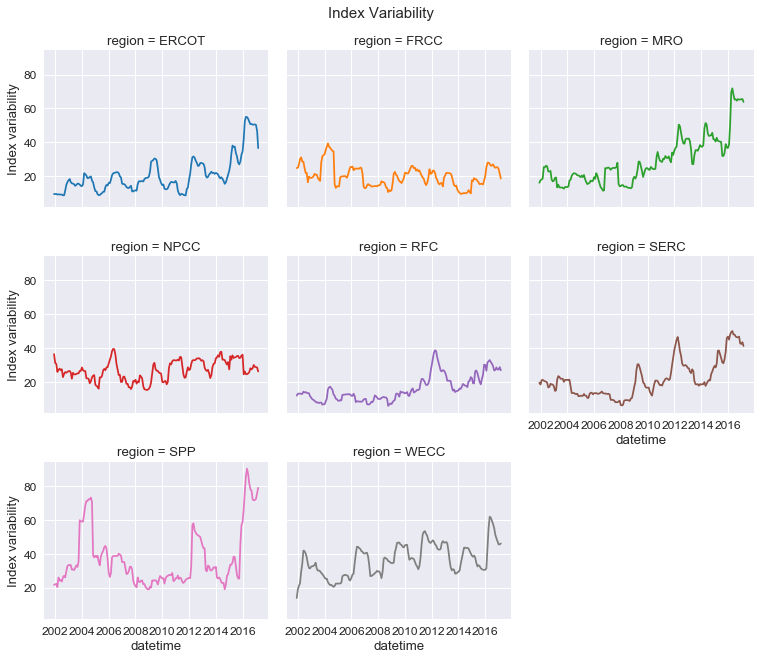

In [28]:
g = sns.FacetGrid(gen_index, col='region', col_wrap=3, hue='region', 
                   aspect = 1.2)
g.map(plt.plot, 'datetime', 'Index variability')
plt.suptitle('Index Variability', y=1.02, size=15)

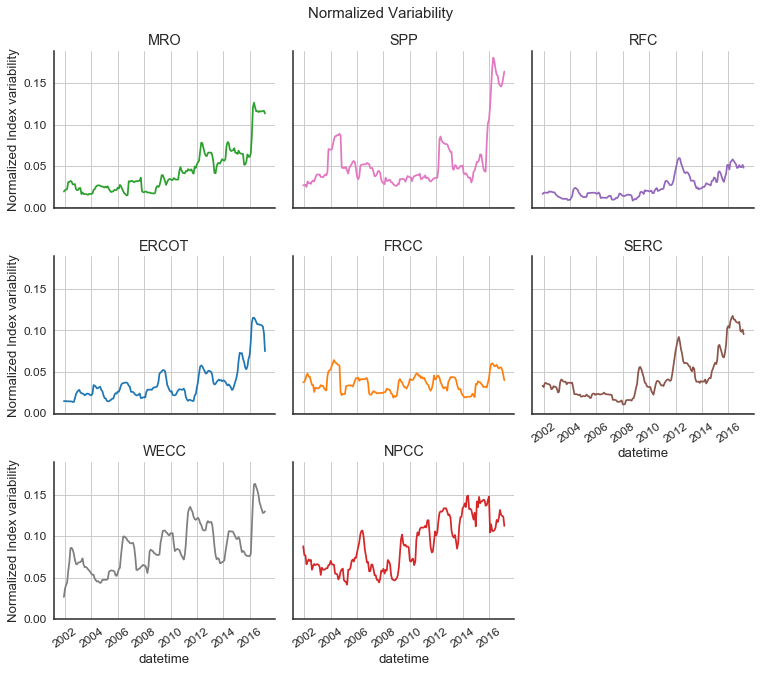

In [102]:
order = ['MRO', 'SPP', 'RFC', 'ERCOT', 'FRCC', 'SERC',
         'WECC', 'NPCC']
g = sns.FacetGrid(gen_index, col='region', col_wrap=3, hue='region', 
                   aspect = 1.2, col_order=order)
g.map(plt.plot, 'datetime', 'Normalized Index variability')
plt.suptitle('Normalized Variability', y=1.02, size=15)
g.set_xticklabels(rotation=35)
axes = g.axes.flatten()
for ax, title in zip(axes, order):
    ax.set_title(title)

### Actual index values over time in each NERC region
**Figure 1 of paper - also include national**

In [94]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})

In [92]:
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': '.15',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.linewidth': 1.5,
 'figure.facecolor': 'white',
 'font.family': [u'sans-serif'],
 'font.sans-serif': [u'Arial',
  u'DejaVu Sans',
  u'Liberation Sans',
  u'Bitstream Vera Sans',
  u'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': u'-',
 'image.cmap': u'rocket',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': u'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': u'out',
 'xtick.major.size': 0.0,
 'xtick.minor.size': 0.0,
 'ytick.color': '.15',
 'ytick.direction': u'out',
 'ytick.major.size': 0.0,
 'ytick.minor.size': 0.0}

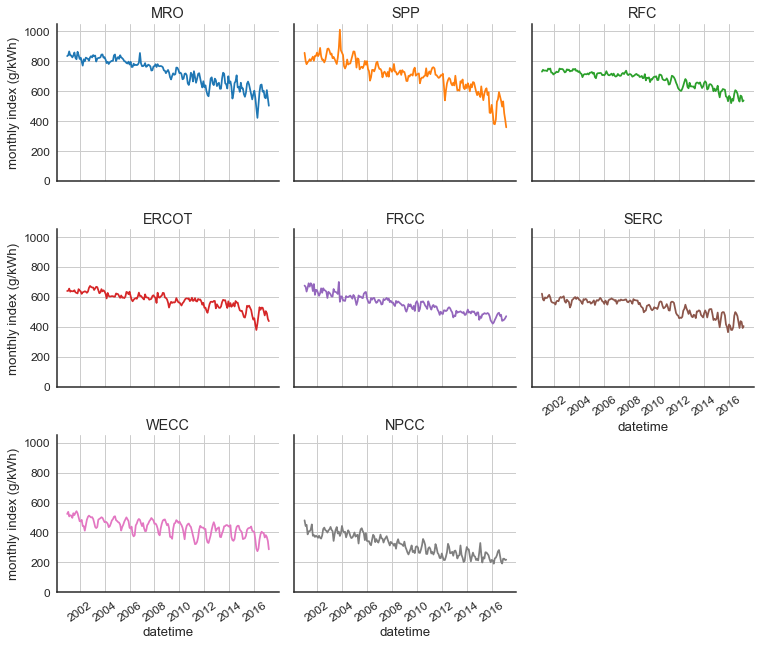

In [95]:
order = ['MRO', 'SPP', 'RFC', 'ERCOT', 'FRCC', 'SERC',
         'WECC', 'NPCC']
g = sns.FacetGrid(gen_index, col='region', col_wrap=3, hue='region',
                   aspect = 1.2, ylim=(0, 1050), col_order=order, hue_order=order)
g.map(plt.plot, 'datetime', 'monthly index (g/kWh)')
g.set_xticklabels(rotation=35)
axes = g.axes.flatten()
for ax, title in zip(axes, order):
    ax.set_title(title)

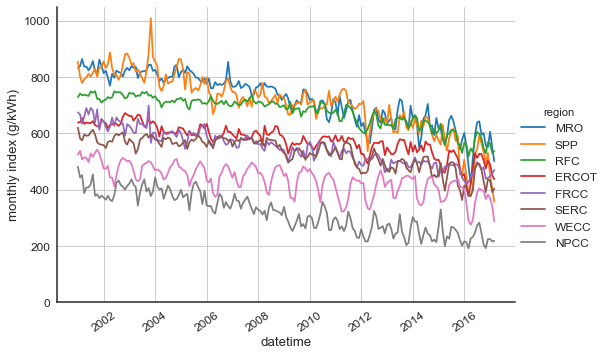

In [96]:
order = ['MRO', 'SPP', 'RFC', 'ERCOT', 'FRCC', 'SERC',
         'WECC', 'NPCC']
g = sns.FacetGrid(gen_index, hue='region', size=5, hue_order=order,
                   aspect = 1.5, ylim=(0, 1050))
g.map(plt.plot, 'datetime', 'monthly index (g/kWh)').add_legend()
g.set_xticklabels(rotation=35)

In [55]:
gen_index.iloc[:, :-15].head()

,region,datetime,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,Year,monthly index (g/kWh),Index variability,Normalized Index variability,Total gen,percent Coal,change in Coal,percent Natural Gas
0,ERCOT,2001-01-01,11683911.0,138093.0,13750546.0,3545310.0,1707467.21,92021.80,0.0,83931.0,2001,638.408119,NaN,NaN,31001280.01,0.376885,-0.053508,0.443548
1,ERCOT,2001-02-01,10236786.0,110148.0,11507834.0,3037626.0,510769.63,81710.37,0.0,141647.0,2001,639.497007,NaN,NaN,25626521.00,0.399461,0.003188,0.449060
2,ERCOT,2001-03-01,11004470.0,180140.0,13316335.0,2462837.0,447733.81,81192.19,0.0,87631.0,2001,654.137303,NaN,NaN,27580339.00,0.398997,0.002024,0.482820
3,ERCOT,2001-04-01,9767225.0,124232.0,14402417.0,2668816.0,331369.06,76768.94,0.0,115487.0,2001,633.521538,NaN,NaN,27486315.00,0.355349,-0.107593,0.523985
4,ERCOT,2001-05-01,11449397.0,115102.0,16025878.0,3419870.0,383202.65,86697.35,0.0,103312.0,2001,638.333358,NaN,NaN,31583459.00,0.362512,-0.089602,0.507414


### Correlation in Index across regions over time

### Percent of national generation from each NERC region

In [31]:
nerc_gen = gen_index.pivot(index='datetime', columns='region', values='Total gen')
regions = nerc_gen.columns
nerc_gen['Total'] = nerc_gen.sum(axis=1)
percent_nerc_gen = nerc_gen.iloc[:, :-1].divide(nerc_gen.iloc[:, -1], axis=0)

In [32]:
percent_nerc_gen.reset_index(inplace=True)

In [33]:
percent_nerc_gen = pd.melt(percent_nerc_gen, id_vars='datetime',
                           value_name='Percent Generation')

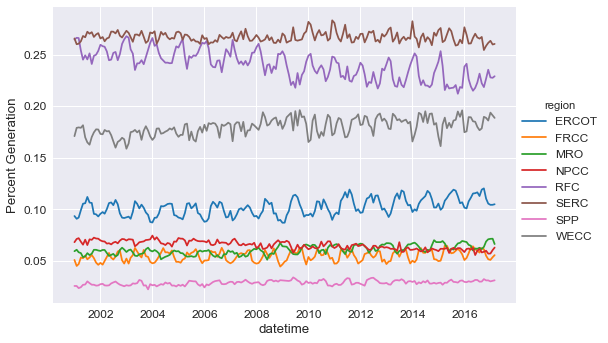

In [34]:
g = sns.FacetGrid(percent_nerc_gen,hue='region', 
                   aspect = 1.5, size=5)
g.map(plt.plot, 'datetime', 'Percent Generation').add_legend()

### Generation in each NERC region in 2015

In [53]:
nerc_gen['Year'] = nerc_gen.index.year
nerc_gen.groupby('Year').sum()

region,ERCOT,FRCC,MRO,NPCC,RFC,SERC,SPP,WECC,Total
Year,,,,,,,,,
2001,3.725800e+08,1.909453e+08,2.161632e+08,2.605056e+08,9.399041e+08,9.938657e+08,9.999798e+07,6.451816e+08,3.719144e+09
2002,3.856285e+08,2.033528e+08,2.243845e+08,2.639318e+08,9.726140e+08,1.031267e+09,1.063719e+08,6.522096e+08,3.839760e+09
2003,3.791997e+08,2.126100e+08,2.270116e+08,2.677912e+08,9.679986e+08,1.036856e+09,1.071944e+08,6.671349e+08,3.865796e+09
2004,3.902991e+08,2.181179e+08,2.255123e+08,2.714832e+08,9.882323e+08,1.059385e+09,1.075122e+08,6.920395e+08,3.952582e+09
2005,3.966687e+08,2.202564e+08,2.289179e+08,2.830366e+08,1.018798e+09,1.074424e+09,1.144705e+08,7.005246e+08,4.037097e+09
2006,4.005829e+08,2.237516e+08,2.300444e+08,2.744769e+08,9.998087e+08,1.070732e+09,1.161386e+08,7.308524e+08,4.046387e+09
2007,4.054923e+08,2.254161e+08,2.374609e+08,2.784050e+08,1.022114e+09,1.106244e+09,1.229413e+08,7.402408e+08,4.138315e+09
2008,4.047878e+08,2.196368e+08,2.435205e+08,2.674164e+08,1.000488e+09,1.085137e+09,1.229592e+08,7.572186e+08,4.101164e+09
2009,3.971679e+08,2.179523e+08,2.407059e+08,2.548166e+08,9.153819e+08,1.049575e+09,1.217441e+08,7.352388e+08,3.932583e+09


### Percent of each fuel used in each NERC region

In [107]:
all_fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Other Renewables',
                 'Wind', 'Solar', 'Hydro']
value_cols = ['percent {}'.format(fuel) for fuel in all_fuels]

percent_gen_df = pd.melt(gen_index, id_vars=['region', 'datetime'], 
        value_vars=value_cols, value_name='percent generation',
                        var_name='fuel')
percent_gen_df['fuel'] = percent_gen_df['fuel'].map(lambda x: x.split()[-1])
percent_gen_df['fuel'].replace('Renewables', 'Other Renewables', inplace=True)
percent_gen_df['fuel'].replace('Gas', 'Natural Gas', inplace=True)

In [38]:
percent_gen_df.head()

,region,datetime,fuel,percent generation
0,ERCOT,2001-01-01,Coal,0.376885
1,ERCOT,2001-02-01,Coal,0.399461
2,ERCOT,2001-03-01,Coal,0.398997
3,ERCOT,2001-04-01,Coal,0.355349
4,ERCOT,2001-05-01,Coal,0.362512


** This could be figure 2?**

In [108]:
percent_gen_df['fuel'].unique()

array(['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Other Renewables',
       'Wind', 'Solar', 'Hydro'], dtype=object)

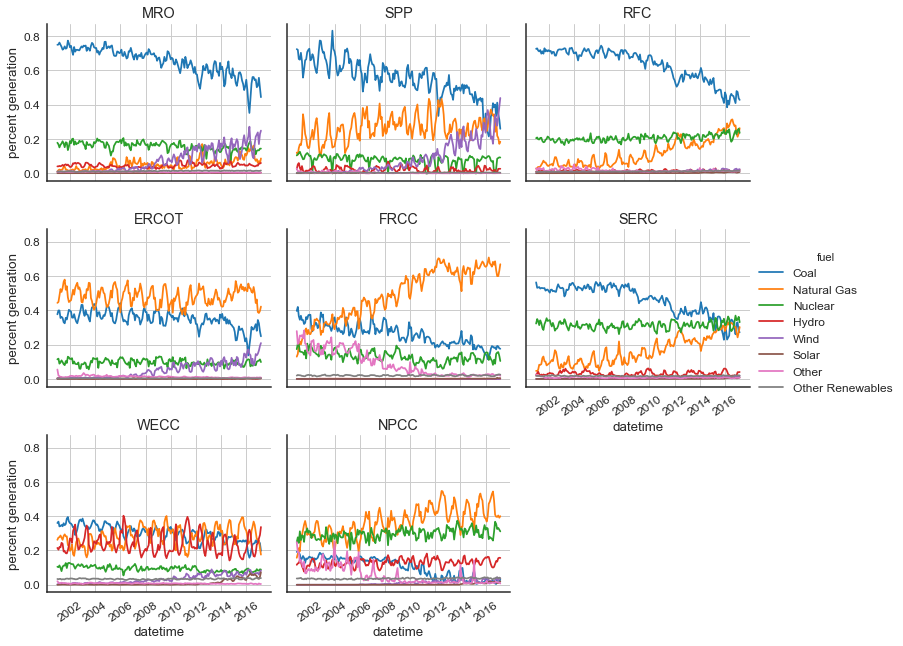

In [110]:
order = ['MRO', 'SPP', 'RFC', 'ERCOT', 'FRCC', 'SERC',
         'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
g = sns.FacetGrid(percent_gen_df, col='region', col_wrap=3, hue='fuel',
                  aspect=1.2, col_order=order, hue_order=fuel_order)
g.map(plt.plot, 'datetime', 'percent generation').add_legend()
g.set_xticklabels(rotation=35)
axes = g.axes.flatten()
for ax, title in zip(axes, order):
    ax.set_title(title)

In [47]:
def region_bokeh_plot(df, fuel, x_axis, y_axis, x_range=None, y_range=None,
                     x_lower_lim=0, x_upper_lim=None):
    figs = {}
    if not x_upper_lim:
        x_upper_lim = df[x_axis].max()
        
    for region in df['region'].unique():
        temp = gen_index.loc[gen_index['region'] == region]
        max_change = temp[x_axis].max()
        
        if max_change <= x_upper_lim and max_change >= x_lower_lim:
            
            source = ColumnDataSource(data=dict(
            x=temp[x_axis],
            y=temp[y_axis],
            datetime=temp['datetime'],
            colors= viridis(len(temp))
            ))
            
            hover = HoverTool(tooltips=[
                                    ("(x,y)", "($x, $y)"),
                                    ("datetime", "@datetime{%F}")],
                             formatters={
                                     'datetime': 'datetime', # use 'datetime' formatter
                                        })
            hover.point_policy = "snap_to_data"

            fuel_2005 = weighted_percent(temp, fuel, 2005)
            fuel_2016 = weighted_percent(temp, fuel, 2016)
            title = region + ' {:.1f}% to {:.1f}% {}'.format(fuel_2005, 
                                                             fuel_2016, fuel)

            figs[region] = figure(title=title, tools=[hover], y_range=y_range, x_range=x_range,
                                 output_backend="webgl")
            figs[region].circle('x', 'y', source=source, color='colors', size=12, alpha=0.5)
            figs[region].xaxis.axis_label = x_axis
            figs[region].yaxis.axis_label = y_axis

    plots = figs.values()
    grid = gridplot(plots, ncols=3, plot_width=240, plot_height=240)

    show(grid)

In [ ]:
figs = {}

for region in percent_gen_df['region'].unique():
    temp = percent_gen_df.loc[percent_gen_df['region'] == region]
    pivoted = pd.pivot_table(temp, index='datetime', columns='fuel')
    pivoted.reset_index(inplace=True, drop=False)

    source = ColumnDataSource(data=dict(
                                        x=pivoted['datetime'],
                                        y=pivoted['percent generation'],
                                        datetime=pivoted['datetime']
                                        ))

#     p = TimeSeries(pivoted, tools='hover')
    hover = HoverTool(tooltips=[
                            ("fuel", "@fuel"),
                            ('% gen', '$y'),
                            ("datetime", "@datetime{%F}")],
                     formatters={
                             'datetime': 'datetime', # use 'datetime' formatter
                                })
    hover.point_policy = "snap_to_data"
    hover.mode = 'vline'
    figs[region] = figure(title=region, tools=[hover],
                         output_backend="webgl")
    figs[region].multi_line('x', 'y', source=source)
    figs[region].xaxis.axis_label = 'datetime'
    figs[region].yaxis.axis_label = 'percent generation'

plots = figs.values()
grid = gridplot(plots, ncols=3, plot_width=240, plot_height=240)

show(grid)

## Variability scatter plots

### Why is variability important? 

Temporal variability is a sign that decarbonization is happening, but unevenly across the year. If the variability is not correlated between regions, better transmission would allow for a more even spread of low-carbon electricity. As the percent of those technologies grows, each region could export excess low(er)-carbon power. But if they are negatively correlated, then each region is going to be generating higher-CO2 power at the same time. New technologies will be necessary to deal with this.

**Ines**: Is there a point where variability becomes of return?
- This is seasonal (monthly data). Grid reliability reports might be more at the hourly level.
- Not even a variability issue. It's just a temporal correlation of Index.

**Paper results subsections** (order could change - method will be in the same order, short paragraphs that explain each):
- Index
- Generagion by region
- State-level
- Correlation across regions
- Variability

Plot ideas (figures 3, 4, and 5):
- Possibly emissions per capita or GDP (could be at state level) - ranking by state? Index, change in index, index per capita (See Sam's figure 2 - bar plots next to each other )
- Coal on X, NG (or fuel) on Y, variability coded by color (or 3 variable triangle plot?)
- Small multiples of variability vs fuel for a single region

For results:
- Think of 1 figure or table for each subsection
- Write 3 sentence punchline about each

### Coal
This set of plots - and the ones repeated below - show:
1. The percent generation from coal in a given month against the percent change in normalized variability from a 2005 annual average
2. The percent change in coal generation from 2005 annual average against the percent change in normalized variability from a 2005 annual average

#### Analysis:
The cleanest relationship that I see is that as coal goes down, variability goes up. The trend is pretty linear, and extends across a bunch of different NERC regions. A few interesting notes:
- SPP sees a steep decline in coal use from ~80% to 20-30%, but the variability doesn't go up until percent coal drops below 40%
- In contrast, RFC sees an immediate linear increase in variability from a similar starting point
- FRCC doesn't see much of an increase in variability despite the drop in coal from ~40% to 10-20%
- The other NERC regions (NPCC, ERCOT, WECC, SERC, RFC, and MRO) all have similar linear responses to the drop in coal use even though they have different starting points for percent of coal

#### Percent Coal vs Change in norm variability

In [48]:
region_bokeh_plot(gen_index, 'Coal', 'percent Coal', 
                  'change in norm variability',
                  y_range=(-1, 7), x_range=(0, 0.85))

#### Change in Coal vs Change in norm variability

In [46]:
region_bokeh_plot(gen_index, 'Coal', 'change in Coal', 
                  'change in norm variability', y_range=(-1, 7))

### Wind

#### Percent Wind vs Change in norm variability

In [43]:
region_bokeh_plot(gen_index, 'Wind', 'percent Wind', 
                  'change in norm variability', 
                  y_range=(-1, 7), x_range=(0, 0.35))

#### Change in Wind vs Change in norm variability

In [44]:
region_bokeh_plot(gen_index, 'Wind', 'change in Wind', 
                  'change in norm variability', y_range=(-1, 7))

### Natural gas

#### Percent Natural Gas vs Change in norm variability

In [47]:
region_bokeh_plot(gen_index, 'Natural Gas', 'percent Natural Gas', 
                  'change in norm variability',
                  y_range=(-1, 7), x_range=(0, 0.75))

#### Change in Natural Gas vs Change in norm variability

In [48]:
region_bokeh_plot(gen_index, 'Natural Gas', 'change in Natural Gas', 
                  'change in norm variability', y_range=(-1, 7))

### Hydro

#### Percent Hydro vs Change in norm variability

In [49]:
region_bokeh_plot(gen_index, 'Hydro', 'percent Hydro', 
                  'change in norm variability',
                  y_range=(-1, 7), x_range=(0, 0.45))

#### Change in Hydro vs Change in norm variability

In [50]:
region_bokeh_plot(gen_index, 'Hydro', 'change in Hydro', 
                  'change in norm variability', y_range=(-1, 7))

### Solar

#### Percent Solar vs Change in norm variability

In [51]:
region_bokeh_plot(gen_index, 'Solar', 'percent Solar', 
                  'change in norm variability',
                  y_range=(-1, 7), x_range=(0, 0.08))

#### Change in Solar vs Change in norm variability

Most NERC regions didn't have recorded solar in 2005, so this plot doesn't make much sense

In [52]:
region_bokeh_plot(gen_index, 'Solar', 'change in Solar', 
                  'change in norm variability', y_range=(-1, 7))

### Nuclear

#### Percent Solar vs Change in norm variability

In [50]:
region_bokeh_plot(gen_index, 'Nuclear', 'percent Nuclear', 
                  'change in norm variability',
                  y_range=(-1, 7), x_range=(0, 0.35))

In [52]:
region_bokeh_plot(gen_index, 'Solar', 'change in Solar', 
                  'change in norm variability', y_range=(-1, 7))